In [1]:
import networkx as nx
from utils import generate_graph, display_weight_stats, plot_communities, naive_sequence

In [2]:
# generate graph with pages as nodes and edges weighted by the cosine similarity
CJ_graph = generate_graph("books/cains_jawbone.txt")

minimum 0.019894622187133587
   mean 0.08425618893009772 +- 0.029549702772006203
maximum 0.3300537936923397


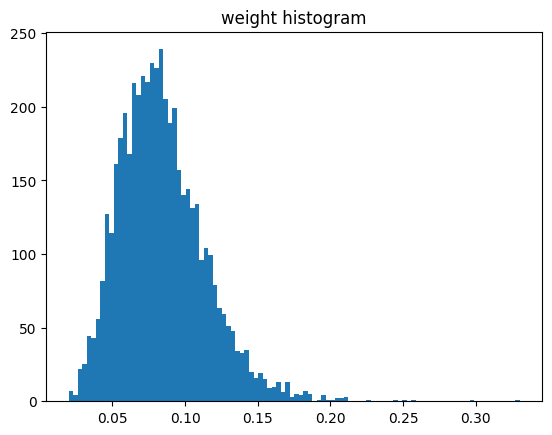

In [3]:
# statistics of cosine similarities
display_weight_stats(CJ_graph)

In [4]:
# detect communities (resolution s.t. 6 communities arise)
CJ_communities = nx.community.louvain_communities(CJ_graph, resolution=1.02, weight="weight", seed=0)

print(len(CJ_communities), "communities:")
for community in CJ_communities:
    print(*sorted(community))

6 communities:
0 2 6 8 14 19 26 27 32 36 50 59 61 68 85 88 91 92 94 95 98
10 15 21 25 37 46 48 57 62 71 76 78 84 86 93
4 9 13 17 18 24 31 35 38 45 47 49 56 60 63 69 87 96
3 7 20 28 29 33 34 39 52 64 65 66 72 75 79 89
1 5 11 12 16 22 30 40 41 42 43 44 51 54 67 70 73 74 77 81 82 83 97 99
23 53 55 58 80 90


c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_node_layout.py:1023: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]
c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


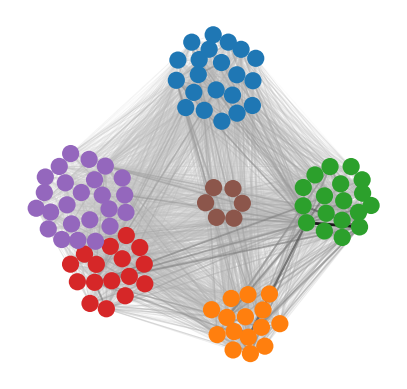

In [5]:
plot_communities(CJ_graph, CJ_communities)

In [6]:
# Graph Traversal Algorithm ???

# maximum spanning tree
# depth first search
# traveling salesman problem
# start at which node
# GNN with "actual" books as training data

In [7]:
path = naive_sequence(CJ_graph, 0)
print(*path, sep=", ")

0, 88, 45, 87, 38, 33, 75, 27, 32, 90, 58, 85, 8, 24, 99, 76, 78, 21, 10, 71, 61, 2, 97, 1, 53, 63, 18, 31, 86, 79, 52, 25, 91, 95, 65, 39, 28, 34, 74, 35, 69, 49, 14, 46, 41, 12, 57, 48, 68, 98, 36, 55, 84, 81, 16, 42, 47, 13, 9, 17, 92, 40, 11, 73, 44, 77, 80, 23, 82, 67, 4, 7, 66, 54, 22, 5, 70, 19, 59, 94, 6, 26, 3, 20, 30, 89, 64, 51, 56, 96, 62, 43, 93, 15, 60, 72, 29, 37, 83, 50
